# Zadanie 6 Pracownia Specjalistyczna - Eksploracja danych
### Krzysztof Funkowski

In [1]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from matplotlib.colors import LinearSegmentedColormap

# Zadanie 6
- Konstrukcja klasyfikatora bayesowskiego na podstawie dwóch wielowymiarowych
rozkładów normalnych o takich samych i o różnych macierzach kowariancji
- Rozpatrzenie przypadków dla dwóch i trzech klas

### Funkcja do generowania zbioru danych na podstawie wielowymiarowego rozkładu normalnego

In [2]:
def generate_dataset_norm(N):
    return np.column_stack((np.random.normal(0, 0.3, N), np.random.normal(0, 0.3, N)))

### Funkcja do generowania zbioru danych wybierając dane z przedziału (0,1)
Wychodzi zbiór który na wykresie przyjmuje formę kwadratu

In [3]:
def generate_dataset_rand(N):
    dataset = []
    for _ in range(N):
        dataset.append([random.random(), random.random()])
        
    return dataset

### Funkcja do rotacji zbiorem danych na podstawie podanego kątu

In [4]:
def rotate(phi):
    rad = np.radians(phi)
    rotation_arr = np.array([[np.cos(rad), np.sin(rad)],
                             [-np.sin(rad), np.cos(rad)]])
    return rotation_arr

### Funkcja do rozciągania zbioru danych

In [5]:
def stretch(x, y):
    stretch_arr = np.array([[x, 0],
                            [0, y]])
    return stretch_arr

### Funkcja do transformacji zbioru danych

In [6]:
def perform_transformation(dataset, rotation_angle, x, y):
    result_dataset = copy.deepcopy(dataset)
    
    stretching = stretch(x, y)
    result_dataset = np.dot(result_dataset, stretching)
    
    rotation = rotate(rotation_angle)
    result_dataset = np.dot(result_dataset, rotation)
    
    return result_dataset

### Funkcja służąca do obliczania kowariancji dla dwóch wektorów

In [7]:
def cov(x, y, x_avg, y_avg):
    elements_count = len(x) # ilość elementów w tablicy
    elements_sum = 0
    
    for x,y in zip(x,y):
        elements_sum = elements_sum + ((x - x_avg)*(y - y_avg)) # sumowanie (x - średnia_arytmetyczna_x) * (y - średnia_arytmetyczna_y)
    
    return elements_sum / (elements_count-1)  # suma dzielona przez liczbę elementów

### Funkcja obliczająca macierz kowariancji dla zbioru danych

In [8]:
def cov_for_dataset(cov_dataset):
    avgs = []
    matrix_shape = cov_dataset.shape[1] # wymiary_macierzy czyli liczba_kolumn_bioru_danych x liczba_kolumn_bioru_danych
    for i in range(matrix_shape):
        avgs.append(cov_dataset[:,i].mean()) # obliczanie średnich dla każdego parametru
    
    matrix = []
    for i in range(matrix_shape):
        matrix_row = []
        for j in range(matrix_shape):
            #matrix_shape*i + j
            res = cov(cov_dataset[:,i],cov_dataset[:,j],avgs[i], avgs[j]) # wyznaczanie kowariancji dla każdej pary parametrów
            matrix_row.append(res) # budowanie wiersza macierzy
        matrix.append(matrix_row) # dodawanie wiersza macierzy do tablicy bazowej
    
    return np.matrix(matrix) # przekształcanie typu tablicy na macierz

### Funkcja do obliczania długości wektora własnego

In [9]:
def eigenvector_len(v1):
    dims = v1.shape[0] # ilość elementów wektora
    length = 0
    
    for i in range(dims):
        val = v1[i].ravel().tolist()[0][0]
        length = length + pow(val,2) # sumowanie elementów podniesionych do kwadratu
        
    
    length = sqrt(length) # pierwiastkowanie wyniku sumy elementów wektora podniesionych do kwadratów
    
    return length # zwracanie długości

### Funkcja normalizująca, zwracająca wartość własną i wektor własny

In [10]:
def eigenvector_normalization(v1):
    eigenvalue = eigenvector_len(v1) # wylicznaie wartości własnej
    eigenvector = v1 / eigenvalue # wyliczanie wektora własnego
    
    return eigenvalue, eigenvector # zwrócenie wartości własnej i wektora własnego

### Pomocnicza funkcja zmieniająca tablicę wektorów własnych w odpowiednią formę macierzy

In [11]:
def rearrange_matrix(eigenvectors):
    res = []

    for i in range(len(eigenvectors)):
        row = eigenvectors[i].ravel().tolist()[0]
        res.append(row)

    return np.matrix(res).T

### Funkcja odpowiadająca za obliczanie wartości własnych i wektorów własnych

In [12]:
def eigenvalues_eigenvectors(matrix, num_iterations):
    n = matrix.shape[0] # jeden z wymiarów macierzy, ponieważ jest kwadratowa to wystarczy tylko jeden
    eigenvalues = [] # lista na wartości własne
    eigenvectors = [] # lista na wektory własne
    
    for i in range(n):
        # losowe dane wektora na początku
        eigenvector = np.random.rand(n,1)
    
        # algorytm iteracyjny wykonywany num_iterations razy
        for _ in range(num_iterations):
            eigenvector = np.dot(matrix, eigenvector) # mnożenie macierzy kowariancji przez wektor 
            eigenvalue, eigenvector = eigenvector_normalization(eigenvector) # normalizacja wektora
            
        # usuwanie z macierzy znalezionej wartości własnej i wektora własnego
        # marix - wartość własna * iloczyn zewnętrzny wektora własnego
        matrix = matrix - eigenvalue * np.multiply(eigenvector,eigenvector.T).T 
        
        eigenvalues.append(eigenvalue) # dodanie znalezionej wartości własnej do listy
        eigenvectors.append(eigenvector) # dodanie znalezionego wektora własnego do listy
        
        
        
    return eigenvalues, rearrange_matrix(eigenvectors) # zwrócenie wartości własnych i wektorów własnych

### Funkcja przeprowadzająca operacje wybielania na zbiorze danych

In [15]:
def whitening(dataset):
    cov_matrix = cov_for_dataset(dataset)
    
    num_iterations = 10000
    eigenvalues, eigenvectors = eigenvalues_eigenvectors(cov_matrix, num_iterations)
    K = eigenvectors
    
    A = np.identity(2) * eigenvalues
    A = np.linalg.inv(np.identity(2) * np.sqrt(eigenvalues)) # INV(I * wartości_własne)
    
    new_dataset = (A * K * np.array(dataset, dtype='double').T).T
    new_dataset = np.array(new_dataset)

    return new_dataset

### Funkcja dyskryminacyjna

In [16]:
def discriminant_function(matrix, x):
    means = []
    
    for col_idx in range(matrix.shape[1]):
        means.append(matrix[:,[col_idx]].mean())
    
    matrix_cov = cov_for_dataset(matrix)
    
    d = x - np.array(means)
    
    det_cov = np.linalg.det(matrix_cov)
    inv_cov = np.linalg.inv(matrix_cov)
    res = -0.5 * np.log(det_cov) - np.dot(np.dot(d.T, inv_cov), d)
    
    return res[0,0]

### Funkcja wyliczająca prawdopodobieństwo wylosowania z jednej z klas

In [17]:
def probability_func(matrix1, matrix2):
    a = matrix1.shape[0]
    b = matrix2.shape[0]
    
    return [a / (a + b), b / (a + b)]

### Przypisanie do wybranej klasy z 2 klas

In [18]:
def assign_class(matrix1, matrix2, x, y):
    p = [x, y]
    
    probability = probability_func(matrix1, matrix2)
    
    matrix1_probability = probability[0]
    matrix2_probability = probability[1]
    
    ca = discriminant_function(matrix1, p)
    cb = discriminant_function(matrix2, p)
    
    a = np.log(matrix1_probability) + ca
    b = np.log(matrix2_probability) + cb

    return [a, b]

### Wybór koloru do mapy cieplnej reprezentującej podział z dwóch klas

In [72]:
def assign_color(matrix1, matrix2, x, y):
    res = assign_class(matrix1, matrix2, x, y)
    a = res[0]
    b = res[1]
    
    if a > b:
        return 0
    elif a == b:
        return 0.5
    else:
        return 1

### Przypisanie do wybranej klasy z 3 klas

In [73]:
def assign_class_3_classes(matrix1, matrix2, matrix3, x, y):
    p = [x, y]
    
    ca = discriminant_function(matrix1, p)
    cb = discriminant_function(matrix2, p)
    cc = discriminant_function(matrix3, p)

    return [ca, cb, cc]

### Wybór koloru do mapy cieplnej reprezentującej podział z trzech klas

In [74]:
def assign_color_3_classes(matrix1, matrix2, matrix3, x, y):
    res = assign_class_3_classes(matrix1, matrix2, matrix3, x, y)
    a = res[0]
    b = res[1]
    c = res[2]
    
    if a > b and a > c:
        return 0.1
    elif b > a and b > c:
        return 0.5
    elif c > a and c > b:
        return 1

### Generowanie rozkładów normalnych

In [55]:
dataset1 = np.array(generate_dataset_norm(100))
dataset2 = np.array(generate_dataset_norm(100))

### Sprawdzenie kowariancji przed wybielaniem

In [56]:
cov_for_dataset(dataset1)

matrix([[ 0.08479669, -0.00780494],
        [-0.00780494,  0.12795771]])

In [57]:
cov_for_dataset(dataset2)

matrix([[ 0.09406387, -0.02718746],
        [-0.02718746,  0.09538028]])

### Wybielanie i macierze kowariancji po operacji

In [58]:
w1 = whitening(dataset1)
cov_for_dataset(w1)

matrix([[1.00000000e+00, 3.85494106e-17],
        [3.85494106e-17, 1.00000000e+00]])

In [59]:
w2 = whitening(dataset2)
cov_for_dataset(w2)

matrix([[ 1.00000000e+00, -4.49416037e-16],
        [-4.49416037e-16,  1.00000000e+00]])

### Transformacje i macierze kowariancji po operacji

In [31]:
t1 = perform_transformation(w1, 0, 0.5, 2)
cov_for_dataset(t1)

matrix([[2.50000000e-01, 1.60365548e-16],
        [1.60365548e-16, 4.00000000e+00]])

In [32]:
t2 = perform_transformation(w2, 90, 0.5, 2) - [6, 8] 
cov_for_dataset(t2)

matrix([[ 4.00000000e+00, -2.66902101e-16],
        [-2.66902101e-16,  2.50000000e-01]])

### Wizualizacja przetransformowanych zbiorów (różne macierze kowariancji)

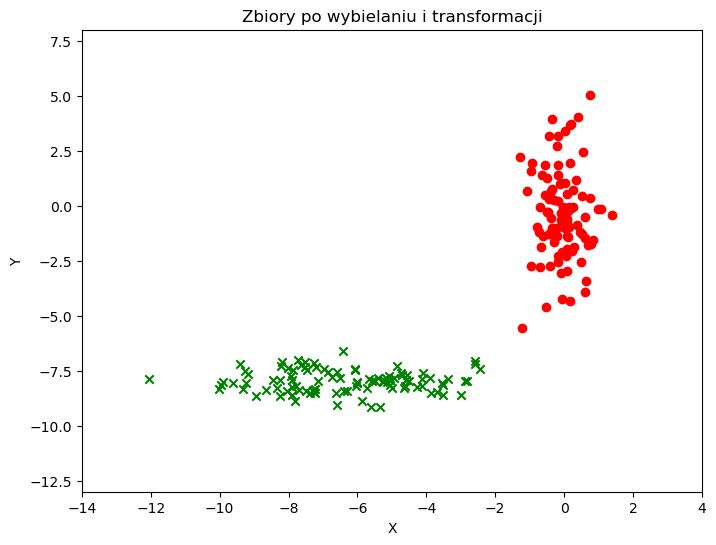

In [33]:
plt.figure(figsize=(8, 6))

plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')

plt.xlabel('X')
plt.ylabel('Y')

plt.xlim(-14, 4)
plt.ylim(-13, 8)

plt.title('Zbiory po wybielaniu i transformacji')
plt.show()

### Ustawienie zakresu generowania mapy

In [48]:
STEP = 0.1
rangex = np.arange(-20, 20 + STEP, STEP)
rangey = rangex

### Kategoryzacja dwóch klas (różne macierze kowariancji)

(4002, 4002)


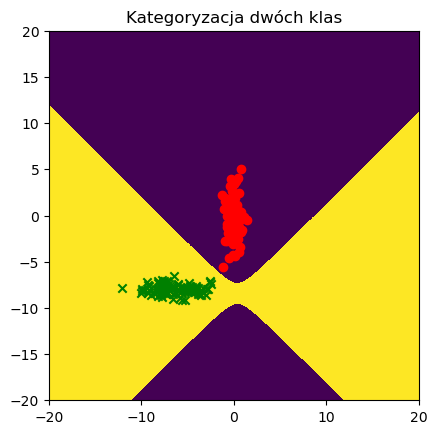

In [41]:
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex]).T
print(heatmap_data.shape)

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')
plt.title('Kategoryzacja dwóch klas')
plt.show()

### Kategoryzacja dwóch klas (takie same macierze kowariancji)

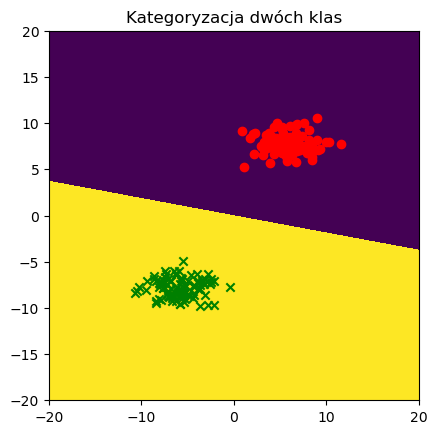

In [42]:
t1 = perform_transformation(w1, 0, 2, 1) + [6, 8]
t2 = perform_transformation(w2, 0, 2, 1) - [6, 8] 
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')
plt.title('Kategoryzacja dwóch klas')
plt.show()

### Kategoryzacja dwóch klas (różne macierze kowariancji) - przed wybielaniem

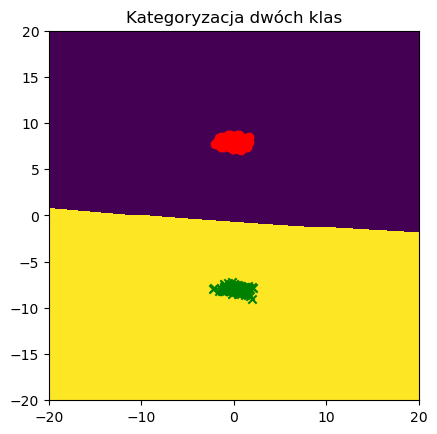

In [68]:
t1 = perform_transformation(dataset1, 0, 3, 1) + [0, 8]
t2 = perform_transformation(dataset2, 0, 3, 1) - [0, 8] 
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')
plt.title('Kategoryzacja dwóch klas')
plt.show()

### Kategoryzacja dwóch klas (takie same macierze kowariancji) - po wybielaniu

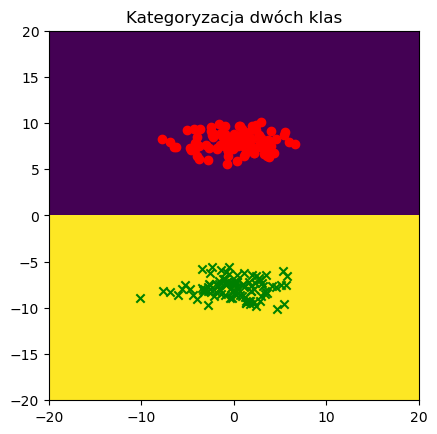

In [66]:
t1 = perform_transformation(w1, 0, 3, 1) + [0, 8]
t2 = perform_transformation(w2, 0, 3, 1) - [0, 8] 
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')
plt.title('Kategoryzacja dwóch klas')
plt.show()

### Kategoryzacja dwóch klas (różne macierze kowariancji)

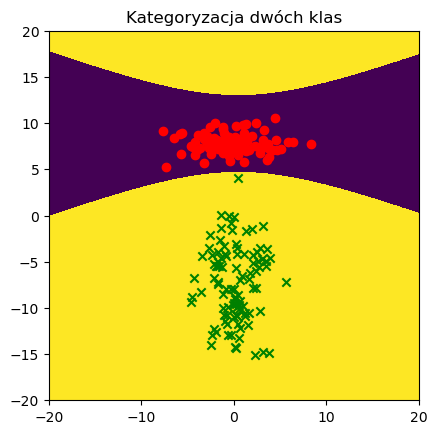

In [44]:
t1 = perform_transformation(w1, 0, 3, 1) + [0, 8]
t2 = perform_transformation(w2, 0, 2, 4) - [0, 8] 
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')
plt.title('Kategoryzacja dwóch klas')
plt.show()

### Kategoryzacja dwóch klas (różne macierze kowariancji)

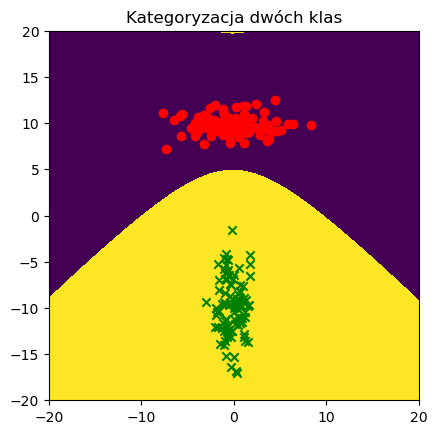

In [45]:
t1 = perform_transformation(w1, 0, 3, 1) + [0, 10]
t2 = perform_transformation(w2, 90, 3, 1) - [0, 10] 
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')
plt.title('Kategoryzacja dwóch klas')
plt.show()

In [82]:
dataset1 = np.array(generate_dataset_norm(100))
dataset2 = np.array(generate_dataset_norm(100))
dataset3 = np.array(generate_dataset_norm(100))
w1 = whitening(dataset1)
w2 = whitening(dataset2)
w3 = whitening(dataset3)

print(f'Macierz kowariancji zbioru 1: \n{cov_for_dataset(w1)}\n')
print(f'Macierz kowariancji zbioru 2: \n{cov_for_dataset(w2)}\n')
print(f'Macierz kowariancji zbioru 3: \n{cov_for_dataset(w3)}\n')

Macierz kowariancji zbioru 1: 
[[1.00000000e+00 2.81060248e-17]
 [2.81060248e-17 1.00000000e+00]]

Macierz kowariancji zbioru 2: 
[[ 1.00000000e+00 -1.05415115e-16]
 [-1.05415115e-16  1.00000000e+00]]

Macierz kowariancji zbioru 3: 
[[1.00000000e+00 1.79429984e-17]
 [1.79429984e-17 1.00000000e+00]]



### Kategoryzacja trzech klas (różne macierze kowariancji) - przed wybielaniem

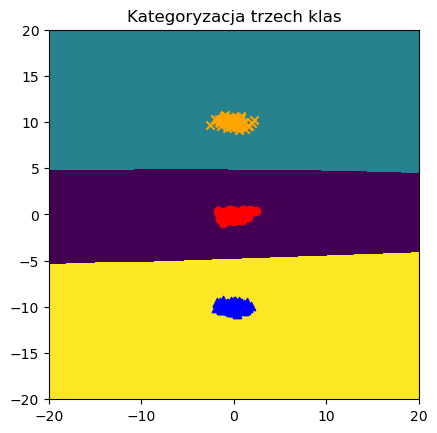

In [83]:
t1 = perform_transformation(dataset1, 0, 3, 1)
t2 = perform_transformation(dataset2, 0, 3, 1) + [0, 10]
t3 = perform_transformation(dataset3, 0, 3, 1) + [0, -10]

heatmap_data = np.array([[assign_color_3_classes(t1, t2, t3, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='orange', marker='x')
plt.scatter(t3[:,[0]], t3[:,[1]], color='blue', marker='^')
plt.title('Kategoryzacja trzech klas')
plt.show()

### Kategoryzacja trzech klas (takie same macierze kowariancji) - po wybielanieu

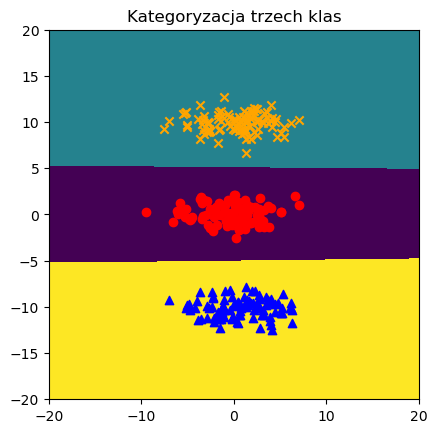

In [84]:
t1 = perform_transformation(w1, 0, 3, 1)
t2 = perform_transformation(w2, 0, 3, 1) + [0, 10]
t3 = perform_transformation(w3, 0, 3, 1) + [0, -10]

heatmap_data = np.array([[assign_color_3_classes(t1, t2, t3, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='orange', marker='x')
plt.scatter(t3[:,[0]], t3[:,[1]], color='blue', marker='^')
plt.title('Kategoryzacja trzech klas')
plt.show()

### Kategoryzacja trzech klas (takie same macierze kowariancji) 

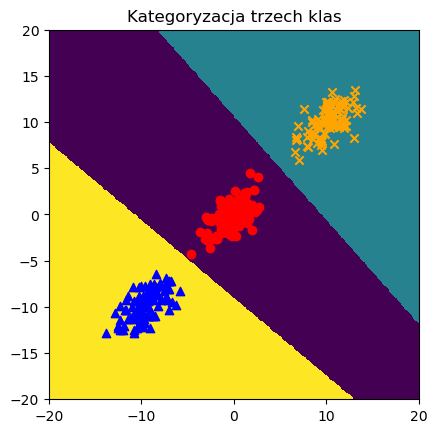

In [86]:
t1 = perform_transformation(w1, 45, 2, 1)
t2 = perform_transformation(w2, 45, 2, 1) + [10, 10]
t3 = perform_transformation(w3, 45, 2, 1) + [-10, -10]

heatmap_data = np.array([[assign_color_3_classes(t1, t2, t3, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='orange', marker='x')
plt.scatter(t3[:,[0]], t3[:,[1]], color='blue', marker='^')
plt.title('Kategoryzacja trzech klas')
plt.show()

### Kategoryzacja trzech klas (takie same macierze kowariancji)

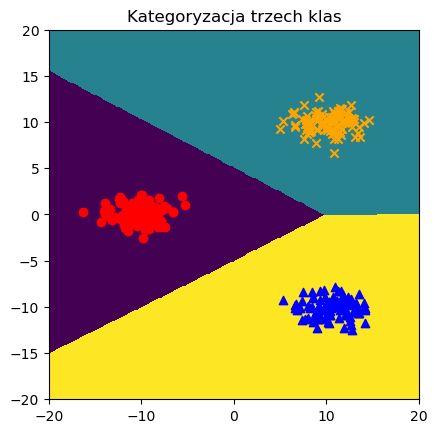

In [89]:
t1 = perform_transformation(w1, 0, 2, 1) + [-10, 0]
t2 = perform_transformation(w2, 0, 2, 1) + [10, 10]
t3 = perform_transformation(w3, 0, 2, 1) + [10, -10]

heatmap_data = np.array([[assign_color_3_classes(t1, t2, t3, x, y) for y in rangey] for x in rangex]).T

plt.imshow(heatmap_data, cmap="viridis", interpolation="nearest", origin='lower', extent=[rangex.min(), rangex.max(), rangey.min(), rangey.max()])
plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='orange', marker='x')
plt.scatter(t3[:,[0]], t3[:,[1]], color='blue', marker='^')
plt.title('Kategoryzacja trzech klas')
plt.show()

### Wnioski

Powyższe testy i zastosowane przykłady pokazują poprawność implementacji reguły decyzyjnej dla 2 lub 3 klas oraz porównanie dla zbiorów danych bez wybielania oraz po wybieleniu.